In [2]:
import sys
import os
XCr_path = os.getcwd()
sys.path.append(XCr_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from XCrystal import *
import time

import XCrTools as tools

In [3]:
delta_theta = 0.0
omega0 = 9000.0

xcr = XCrystal(XCr_path+'/Crystal.yaml', omega0)
xtools = tools.XCrTools(xcr)

xcr.tgrid = 300
xcr.tmax = 50 * 1.0e-15
sigma_t = 3 * 1.0e-15

In [4]:
print('Bragg angle: ', xcr.alphaB * 180 / np.pi)

Bragg angle:  30.48558327729669


In [5]:
xcr.zR / xcr.convr

65011698597207.33

In [6]:
E_txy = np.zeros((xcr.tgrid, xcr.xgrid, xcr.ygrid), dtype=complex)

In [7]:
t = np.linspace(0, xcr.tmax, xcr.tgrid)
dt = t[1] - t[0]
phi = 0 * 2.0*np.pi*((t - xcr.tmax / 2.0) / 2.0)**3
E0 = np.exp(-(t - xcr.tmax / 2.0)**2 / 2.0 / sigma_t**2) * np.exp(1.j * phi)

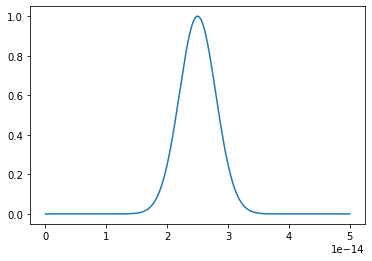

In [8]:
plt.plot(t, np.real(E0))

In [9]:
for i in range(0, xcr.tgrid):
    E_txy[i, :, :] = E0[i] * xtools.Gaussian_2D(xcr, xcr.alphaB)

pad_shape = [(xcr.tpad, xcr.tpad), (0, 0), (0, 0)]
E_txy_padded = xtools.my_pad(E_txy, pad_shape)

E_wxy_padded = np.fft.fftshift(np.fft.fft(E_txy_padded, axis=0), axes=0) 

coeff = 2.0 * np.pi * xcr.hbar
w = np.fft.fftshift(coeff * np.fft.fftfreq(xcr.tgrid + 2 * xcr.tpad, dt))

#E_wxy_padded_phased = E_wxy_padded * np.exp(1j * 2.0 * np.pi * w * (xcr.tgrid / 2 + xcr.tpad) * dt)

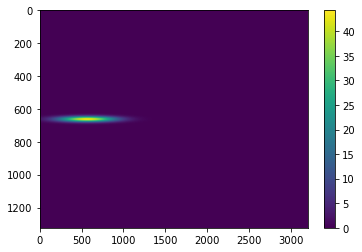

In [10]:
plt.imshow(np.abs(E_wxy_padded[:, :, 5]), aspect='auto')
plt.colorbar()

(-0.5, 0.5)

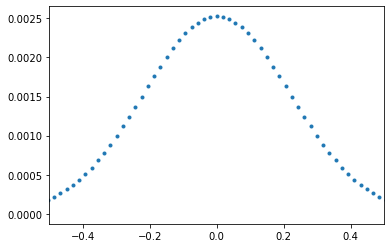

In [11]:
plt.plot(w, np.abs(E_wxy_padded[:, 1600, 5]), '.')
plt.xlim(-0.5, 0.5)

In [11]:
t_crop = 10
E_wxy_sim = xtools.crop_3d_wavefront(E_wxy_padded, cropping_factors=[t_crop, 1, 1])
w_sim = w[int(len(w)/2 - len(w)/t_crop/2):int(len(w)/2 + len(w)/t_crop/2)]

Cropped pump field to a new shape (t, x, y):  55 3200 10


In [12]:
w_sim

array([-1.24546079, -1.20098005, -1.1564993 , -1.11201856, -1.06753782,
       -1.02305708, -0.97857633, -0.93409559, -0.88961485, -0.84513411,
       -0.80065336, -0.75617262, -0.71169188, -0.66721114, -0.62273039,
       -0.57824965, -0.53376891, -0.48928817, -0.44480742, -0.40032668,
       -0.35584594, -0.3113652 , -0.26688445, -0.22240371, -0.17792297,
       -0.13344223, -0.08896148, -0.04448074,  0.        ,  0.04448074,
        0.08896148,  0.13344223,  0.17792297,  0.22240371,  0.26688445,
        0.3113652 ,  0.35584594,  0.40032668,  0.44480742,  0.48928817,
        0.53376891,  0.57824965,  0.62273039,  0.66721114,  0.71169188,
        0.75617262,  0.80065336,  0.84513411,  0.88961485,  0.93409559,
        0.97857633,  1.02305708,  1.06753782,  1.11201856,  1.1564993 ])

In [13]:
Npoints = len(E_wxy_sim)
print(Npoints)
Rs = np.zeros(Npoints)
Ts = np.zeros(Npoints)

55


In [14]:
def single_realization(delta_theta, w_ind):
    
    omega = omega0 + w_sim[w_ind]

    xcr = XCrystal(XCr_path+'/Crystal.yaml', omega)
    xcr.configure(delta_theta, E_wxy_sim[w_ind,:,:])
    xcr.run3D()
    
    return xcr.Reflectivity, xcr.Transmission


def single_realization_with_data(delta_theta, w_ind):
    
    omega = omega0 + w_sim[w_ind]

    xcr = XCrystal(XCr_path+'/Crystal.yaml', omega)
    xcr.configure(delta_theta, E_wxy_sim[w_ind,:,:])
    xcr.run3D()
    
    return xcr.Reflectivity, xcr.Transmission, xcr.U1_field, xcr.U2_field

In [15]:
U1_data = []
U2_data = []

for i in range(0, Npoints):
    print(' ')
    print('iteration: ', i+1, '  dw: ', w_sim[i])
    
    Rs[i], Ts[i], U1_wxyz, U2_wxyz = single_realization_with_data(delta_theta, i)
    
    U1_data.append(U1_wxyz)
    U2_data.append(U2_wxyz)

U1_wxyz = np.asarray(U1_data)
U2_wxyz = np.asarray(U2_data)

 
iteration:  1   dw:  -1.2454607898793721
Delta theta:  0.0 ; Reflectivity:  0.05012832531760087 ; Transmission:  0.32929679433189885
 
iteration:  2   dw:  -1.2009800473836802
Delta theta:  0.0 ; Reflectivity:  0.05407635306474731 ; Transmission:  0.3319726877905525
 
iteration:  3   dw:  -1.1564993048879884
Delta theta:  0.0 ; Reflectivity:  0.035763547357643144 ; Transmission:  0.34216447443468556
 
iteration:  4   dw:  -1.1120185623922965
Delta theta:  0.0 ; Reflectivity:  0.014834052670972625 ; Transmission:  0.3525790222970895
 
iteration:  5   dw:  -1.0675378198966048
Delta theta:  0.0 ; Reflectivity:  0.00803917069785098 ; Transmission:  0.35748838291992346
 
iteration:  6   dw:  -1.023057077400913
Delta theta:  0.0 ; Reflectivity:  0.014430776654268512 ; Transmission:  0.35761382587107554
 
iteration:  7   dw:  -0.9785763349052209
Delta theta:  0.0 ; Reflectivity:  0.021486277216991114 ; Transmission:  0.3576230456371139
 
iteration:  8   dw:  -0.9340955924095291
Delta theta:

(-0.5, 0.5)

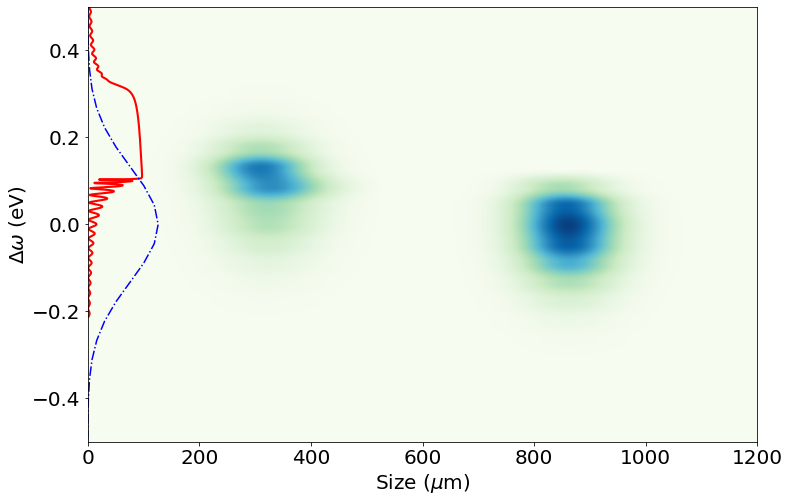

In [20]:
extent = [0, xcr.xxmax / xcr.convr * 1e6, np.max(w_sim), np.min(w_sim)]
plt.imshow(np.abs(U1_wxyz[:,:,5,-1])**2 + np.abs(U2_wxyz[:,:,5,-1])**2, aspect='auto', extent=extent, cmap='GnBu')
plt.xlabel(r'Size ($\mu$m)')
plt.ylabel(r'$\Delta \omega$ (eV)')
plt.plot(100*XOPdata[:,1], dw, '-', linewidth=2.1, color='red')

plt.plot(np.abs(E_wxy_padded[:, 1600, 5])*3e4, w, '-.', color='blue')

plt.ylim(-0.5, 0.5)

In [ ]:
plt.imshow(np.abs(U2_wxyz[19,:,5,:]), aspect='auto')

In [ ]:
plt.plot(np.abs(np.fft.fftshift(np.fft.ifft(U1_wxyz[:,600,5,-1]))))
plt.plot(np.abs(np.fft.fftshift(np.fft.ifft(U1_wxyz[:,300,5,-1]))))

In [ ]:
pad_shape = [(xcr.tpad, xcr.tpad), (0, 0), (0, 0), (0,0)]
U1_wxyz_padded = xtools.my_pad(U1_wxyz, pad_shape)
U1_txyz = np.fft.fftshift(np.fft.ifft(U1_wxyz_padded, axis=0), axes=0)

In [ ]:
plt.imshow(np.abs(U1_txyz[:,:,5,-1]), aspect='auto')

In [17]:
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20

In [18]:
XOPfile = 'Si4009keVThickness50um'
XOPdata = np.loadtxt(XOPfile)

Text(0.5, 0, '$\\Delta \\omega$ (eV)')

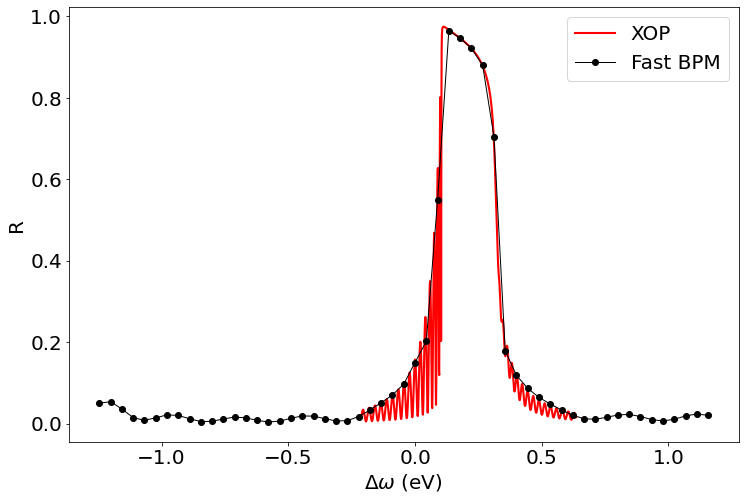

In [19]:
#alphaB = xcr.alphaB
dw = XOPdata[:,0]*4.848137 * 1e-6 * omega0 / np.tan(xcr.alphaB)

plt.plot(dw, XOPdata[:,1], '-', linewidth=2.1, color='red', label='XOP')
plt.plot(w_sim, Rs, 'o-', linewidth=1.0, color='black', label='Fast BPM')


plt.legend()
#plt.xlabel(r'$\Delta \theta$ (urad)')
plt.ylabel('R')
plt.xlabel(r'$\Delta \omega$ (eV)')
